# Import Librerie e dataset



Import delle librerie

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
!pip install keras_tuner

     |████████████████████████████████| 96 kB 3.1 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=749c5d06e38b9c6cdfd174dc8814e9793b44f41b5fc65098af99a3f32621a421
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [3]:
import pandas as pd
from sklearn import preprocessing
from sklearn import utils
import matplotlib.pyplot as plt
import numpy as np
from string import punctuation
import string
import re
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
import keras_tuner as kt

In [4]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import del dataset

In [5]:
#Read dataset
path = ['/content/drive/My Drive/Uni Magistrale/Machine Learning/Progetto ML/commonlitreadabilityprize/train.csv',
        '/content/drive/My Drive/Uni Magistrale/Machine Learning/Progetto ML/commonlitreadabilityprize/test.csv',
        '/content/drive/My Drive/Uni Magistrale/Machine Learning/Progetto ML/AoA_51715_words/AoA_51715_words.xlsx']
df_train= pd.read_csv(path[0])
df_test = pd.read_csv(path[1])

age_df = pd.read_excel(path[2])
df_train['excerpt'] = df_train['excerpt'].str.lower()
#df_train['excerpt_processed']= df_train['excerpt'].replace('[^a-zA-Z0-9]', ' ', regex = True)

print(df_train.head())
print(df_test.head())
print(age_df.head())

          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805
2  b69ac6792       NaN  ... -0.580118       0.476676
3  dd1000b26       NaN  ... -1.054013       0.450007
4  37c1b32fb       NaN  ...  0.247197       0.510845

[5 rows x 6 columns]
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...
2  0df072751  ...  It was a bright and cheerful scene that greete...
3  04caf4e0c  ...  Cell division is the process by which a parent...
4  0e63f8bea  ...  Debugging is the process of finding and resolv...

[5 rows x 4 columns]
       Word Alternative.spelling  ...  AoA_Cort_lem AoA_Schock
0         a                    a  ...           NaN        NaN
1  aardvark             aardvark  ...           NaN        NaN
2    abacus               abacus  .

# Preprocessing dataset

## Creazione colonna in df_train alla frequenza

In [ ]:
modified_df = age_df[ age_df["Freq_pm"].map(str)!="nan"]
modified_df.index= modified_df["Word"]

modified_df= modified_df["Freq_pm"]

freq_dict= modified_df.to_dict()

print(len(freq_dict))
print(type(freq_dict))
print(freq_dict)

51046
<class 'dict'>
{'a': 20415.274509803923, 'aardvark': 0.4117647058823529, 'abacus': 0.23529411764705882, 'abacuses': 0.0196078431372549, 'abalone': 0.5098039215686274, 'abalones': 0.11764705882352941, 'abandon': 8.098039215686274, 'abandoned': 13.294117647058824, 'abandoner': 0.0196078431372549, 'abandoning': 1.6862745098039216, 'abandonment': 0.9607843137254902, 'abandons': 0.27450980392156865, 'abase': 0.058823529411764705, 'abasement': 0.0, 'abate': 0.09803921568627451, 'abated': 0.0784313725490196, 'abatement': 0.058823529411764705, 'abates': 0.0392156862745098, 'abating': 0.0196078431372549, 'abattoir': 0.13725490196078433, 'abbess': 0.0392156862745098, 'abbesses': 0.0196078431372549, 'abbey': 3.176470588235294, 'abbot': 0.8431372549019608, 'abbreviate': 0.0196078431372549, 'abbreviated': 0.3137254901960784, 'abbreviation': 0.23529411764705882, 'abbreviations': 0.19607843137254902, 'abdicate': 0.17647058823529413, 'abdicated': 0.13725490196078433, 'abdicates': 0.0196078431372

In [ ]:
def get_freq(parola):
    try:
        return freq_dict.get(parola, 0.5)
    except KeyError:
        print("chiave non esistente")
        return 0.6
    except Exception as e:
        print(e)
        return 1

print(get_freq("abacuses"))
print(get_freq("abacus"))

0.0196078431372549
0.23529411764705882


In [ ]:
def freq_text(series):
    print(series.shape)
    #series è una Serei che ha come shape (2834,). Si hanno quindi i paragrafi
    serie=[]
    for paragrafo in series:
        #paragrafo è una Stringa che ha lunghezza x, dove x è il numero di parole
        paragrafo=paragrafo.split()
        #print(type(paragrafo))
        #print(len(paragrafo))
        serie_paragrafo=[]
        for parola in paragrafo:
            serie_paragrafo.append(get_freq(parola))
            #print(f"{parola}, {get_aoa(parola)}")
        serie.append(np.mean(serie_paragrafo))
    return serie


df_train["frequenza"]= freq_text(df_train['excerpt'])
print(df_train["frequenza"])

(2834,)
0       6421.830704
1       5730.865878
2       4859.861564
3       5282.500179
4       6934.331333
           ...     
2829    5250.733198
2830    6304.798003
2831    8181.136687
2832    6384.165621
2833    4069.374966
Name: frequenza, Length: 2834, dtype: float64


## Creazione colonna Aoa

In [ ]:
#prendo le righe che hanno percentuale non nulla
modified_df = age_df[ age_df["AoA_Kup_lem"].map(str)!="nan"]

modified_df.index= modified_df["Word"]

modified_df= modified_df["AoA_Kup_lem"]

aoa_dict= modified_df.to_dict()

print(len(aoa_dict))
print(type(aoa_dict))
print(aoa_dict)

51695
<class 'dict'>
{'a': 2.8933839999999993, 'aardvark': 9.89, 'abacus': 8.69, 'abacuses': 8.69, 'abalone': 12.23, 'abalones': 12.23, 'abandon': 8.32, 'abandoned': 8.32, 'abandoner': 11.89, 'abandoning': 8.32, 'abandonment': 10.27, 'abandons': 8.32, 'abase': 14.57, 'abasement': 15.130969, 'abate': 14.44, 'abated': 14.44, 'abatement': 15.12, 'abates': 14.44, 'abating': 14.44, 'abattoir': 15.17, 'abbacy': 14.5, 'abbess': 15.43, 'abbesses': 15.43, 'abbey': 13.06, 'abbot': 12.104381, 'abbreviate': 9.95, 'abbreviated': 10.5, 'abbreviation': 9.11, 'abbreviations': 9.11, 'abdicate': 12.6, 'abdicated': 12.6, 'abdicates': 12.6, 'abdicating': 12.6, 'abdication': 14.94, 'abdomen': 8.61, 'abdomens': 8.61, 'abdominal': 10.24, 'abduct': 11.26, 'abducted': 11.26, 'abducting': 11.26, 'abduction': 11.94, 'abductions': 11.94, 'abductor': 11.11, 'abductors': 11.11, 'abducts': 11.26, 'abeam': 13.4, 'aberrant': 13.31, 'aberration': 12.69, 'aberrations': 12.69, 'abet': 12.15, 'abetted': 12.15, 'abetting':

In [ ]:
def get_aoa(parola):
    try:
        return aoa_dict.get(parola, 0.5)
    except KeyError:
        print("chiave non esistente")
        return 0.6
    except Exception as e:
        print(e)
        return 1

print(get_aoa("abacuses"))
print(get_aoa("abacus"))

8.69
8.69


In [ ]:
def aoa_text(series):
    print(series.shape)
    #series è una Serei che ha come shape (2834,). Si hanno quindi i paragrafi
    serie=[]
    for paragrafo in series:
        #paragrafo è una Stringa che ha lunghezza x, dove x è il numero di parole
        paragrafo=paragrafo.split()
        #print(type(paragrafo))
        #print(len(paragrafo))
        serie_paragrafo=[]
        for parola in paragrafo:
            serie_paragrafo.append(get_aoa(parola))
            #print(f"{parola}, {get_aoa(parola)}")
        serie.append(np.mean(serie_paragrafo))
    return serie


df_train["aoa"]=aoa_text(df_train['excerpt'])
print(df_train["aoa"][0:200])

(2834,)
0      4.084183
1      3.485596
2      3.591065
3      4.098703
4      3.434248
         ...   
195    3.504266
196    4.283427
197    4.365302
198    4.104419
199    3.894647
Name: aoa, Length: 200, dtype: float64


## Creazione colonna per parole conosciute.

In [ ]:
#prendo le righe che hanno percentuale non nulla
modified_df = age_df[ age_df["Perc_known_lem"].map(str)!="nan"]

modified_df.index= modified_df["Word"]


modified_df= modified_df["Perc_known_lem"]

perc_known_dict= modified_df.to_dict()

print(len(perc_known_dict))
print(type(perc_known_dict))
print(perc_known_dict)

51715
<class 'dict'>
{'a': 1.0, 'aardvark': 1.0, 'abacus': 0.65, 'abacuses': 0.65, 'abalone': 0.7222222222222222, 'abalones': 0.7222222222222222, 'abandon': 1.0, 'abandoned': 1.0, 'abandoner': 0.9473684210526315, 'abandoning': 1.0, 'abandonment': 1.0, 'abandons': 1.0, 'abase': 0.7368421052631579, 'abasement': 0.631578947368421, 'abate': 0.9473684210526315, 'abated': 0.9473684210526315, 'abatement': 0.8095238095238095, 'abates': 0.9473684210526315, 'abating': 0.9473684210526315, 'abattoir': 0.3157894736842105, 'abbacy': 0.09523809523809523, 'abbess': 0.3684210526315789, 'abbesses': 0.3684210526315789, 'abbey': 0.8571428571428571, 'abbot': 0.75, 'abbreviate': 1.0, 'abbreviated': 1.0, 'abbreviation': 1.0, 'abbreviations': 1.0, 'abdicate': 0.8333333333333334, 'abdicated': 0.8333333333333334, 'abdicates': 0.8333333333333334, 'abdicating': 0.8333333333333334, 'abdication': 0.8888888888888888, 'abdomen': 1.0, 'abdomens': 1.0, 'abdominal': 0.9444444444444444, 'abduct': 1.0, 'abducted': 1.0, 'a

In [ ]:
def get_per_known(parola):
    try:
        return perc_known_dict.get(parola, 0.5)
    except KeyError:
        print("chiave non esistente")
        return 0.6
    except Exception as e:
        print(e)
        return 1

print(get_per_known("abacuses"))
print(get_per_known("abacus"))

0.65
0.65


In [ ]:
def per_known_text(series):
    print(series.shape)
    #series è una Serei che ha come shape (2834,). Si hanno quindi i paragrafi
    serie=[]
    for paragrafo in series:
        #paragrafo è una Stringa che ha lunghezza x, dove x è il numero di parole
        paragrafo=paragrafo.split()
        #print(type(paragrafo))
        #print(len(paragrafo))
        serie_paragrafo=[]
        for parola in paragrafo:
            serie_paragrafo.append(get_per_known(parola))
            #print(f"{parola}, {get_aoa(parola)}")
        serie.append(np.mean(serie_paragrafo))
    return serie


df_train["perc_known"]= per_known_text(df_train['excerpt'])
print(df_train["perc_known"])

(2834,)
0       0.906953
1       0.831343
2       0.838847
3       0.888137
4       0.885086
          ...   
2829    0.907586
2830    0.932574
2831    0.931390
2832    0.910290
2833    0.858160
Name: perc_known, Length: 2834, dtype: float64


## Creazione colonna parole uniche nel testo

*Tendenzialmente, una parola che compare una sola volta in tutto il dataset è una parola ricercata, complessa. Invece, una parola che compare tante volte è semplice, si usa più normalmente in una frase. Questa ricerca trova queste parole.*

Per ogni testo, si aggiorna il conteggio delle parole e si trovano le parole che non compaiono in nessun altro testo. Queste parole vengono poi riviste perchè un parola, anche se unica all'interno del dataset, potrebbe essere comunque semplice. Nel dataset si creerà quindi una nuova colonna che indica quante sono queste parole.

In [ ]:
def mostra_lista(lista):
  n = len(lista)
  for i in range(0, n, 10):
    s = ""
    s = s + lista[i]
    for j in range(1, 11):
      if (i + j) < n:
        s = s + " - " + lista[i + j]
      else:
        break
    print(s)

In [ ]:
def mostra_dizionario(diz):
  chiavi = list(diz.keys())
  n = len(chiavi)
  i = 0
  print(n)
  for i in range(0, n, 10):
    c1 = ""
    c2 = ""
    s = ""
    v1 = -1
    v2 = -1

    c1 = chiavi[i]
    v1 = diz[c1]
    s = s + c1 + " -> " + str(v1)
    for j in range(1, 11):
      if (i + j) < n:
        c2 = chiavi[i+j]
        v2 = diz[c2]
        s = s + "   -   " + c2 + " -> " + str(v2)
      else:
        break
    
    print(s)

In [ ]:
def conteggio_word(dataset):
  parole_uniche = list()
  conteggio_parole = dict()
  for n in range(len(dataset)):
    e = dataset['excerpt'][n]
    e = e.translate(str.maketrans('', '', string.punctuation))
    e = e.split()
    for p in e:
      if p in conteggio_parole:
        conteggio_parole[p] += 1
      else:
        conteggio_parole[p] = 0
    n += 1

  for p in conteggio_parole:
    if conteggio_parole[p] == 0:
      parole_uniche.append(p)

  print("Esistono ", len(conteggio_parole), " parole diverse!")
  stampa = input("Stampare l'intero dizionario di parole? [0] è no     ---> ")
  if stampa != str(0):
    print("Le parole sono:")
    mostra_dizionario(conteggio_parole)

  print("Esistono ", len(parole_uniche), "parole uniche!")
  stampa = input("Stampare le parole uniche? [0] è no     ---> ")
  if stampa != str(0):
    print("Le parole uniche sono:")
    mostra_lista(parole_uniche)

In [ ]:
conteggio_word(df_train)
df_train.head()

Esistono  30112  parole diverse!
Stampare l'intero dizionario di parole? [0] è no     ---> 0
Esistono  13925 parole uniche!
Stampare le parole uniche? [0] è no     ---> 0


id url_legal license  ...    frequenza       aoa  perc_known
0  c12129c31       NaN     NaN  ...  6421.830704  4.084183    0.906953
1  85aa80a4c       NaN     NaN  ...  5730.865878  3.485596    0.831343
2  b69ac6792       NaN     NaN  ...  4859.861564  3.591065    0.838847
3  dd1000b26       NaN     NaN  ...  5282.500179  4.098703    0.888137
4  37c1b32fb       NaN     NaN  ...  6934.331333  3.434248    0.885086

[5 rows x 9 columns]

In [ ]:
df_train['parole_uniche'] = 0

for n in range(df_train.shape[0]):
  for p in parole_uniche:
    if p in df_train['excerpt'][n]:
      df_train['parole_uniche'][n] += 1
  n += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
df_train.head()

id url_legal license  ...       aoa  perc_known  parole_uniche
0  c12129c31       NaN     NaN  ...  4.084183    0.906953             57
1  85aa80a4c       NaN     NaN  ...  3.485596    0.831343             46
2  b69ac6792       NaN     NaN  ...  3.591065    0.838847             44
3  dd1000b26       NaN     NaN  ...  4.098703    0.888137             48
4  37c1b32fb       NaN     NaN  ...  3.434248    0.885086             12

[5 rows x 10 columns]

## Creazione colonne numero frasi e lunghezza media delle frasi.


*Il numero di frasi potrebbe influire e la loro lunghezza media possono influire sulla difficoltà di lettura di un testo.*

In [ ]:
def lunghezza_frasi(dataset):
  dataset['num_frasi'] = 0
  dataset['lung_media_frasi'] = 0
  for n in range(len(dataset)):
    frasi = dict()
    n_frase = str(1)
    frasi[n_frase] = 0
    somma = 0

    e = dataset['excerpt'][n]
    e = re.findall(r"[\w']+|[.,!?;]", e)
    #inserisco il punto finale per fare in modo che anche l'ultima risulti come frase compiuta
    e.append(".")

    for parola in e:
      if parola in ['.',',','!','?',';']:
        n_frase = str(int(n_frase) + 1)
        frasi[n_frase] = 0
      else:
        frasi[n_frase] += 1
    
    dataset['num_frasi'][n] = n_frase
    
    for f in frasi:
      somma += frasi[f]
    
    dataset['lung_media_frasi'][n] = round(somma / int(n_frase))
    
    n += 1


In [ ]:
lunghezza_frasi(df_train)
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


id url_legal license  ... parole_uniche  num_frasi  lung_media_frasi
0  c12129c31       NaN     NaN  ...            57         27                 7
1  85aa80a4c       NaN     NaN  ...            46         43                 4
2  b69ac6792       NaN     NaN  ...            44         33                 5
3  dd1000b26       NaN     NaN  ...            48         32                 5
4  37c1b32fb       NaN     NaN  ...            12         30                 5

[5 rows x 12 columns]

Colonna per rapporto fra parole uniche e numero parole.

*Questo valore può indicare quante parole sono di uso poco comune all'interno di un testo. Il valore è una percentuale.*

In [ ]:
def numero_parole(dataset):
  dataset['num_parole'] = 0
  dataset['unicità'] = 0.0
  for n in range(len(dataset)):
    num_parole = 0
    testo = dataset['excerpt'][n]
    testo = testo.split()
    dataset['num_parole'][n] = len(testo)
    dataset['unicità'][n] = round((dataset['parole_uniche'][n] * 100)/len(testo), 3)

    n += 1

In [ ]:
numero_parole(df_train)
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


id url_legal license  ... lung_media_frasi  num_parole  unicità
0  c12129c31       NaN     NaN  ...                7         179   31.844
1  85aa80a4c       NaN     NaN  ...                4         169   27.219
2  b69ac6792       NaN     NaN  ...                5         166   26.506
3  dd1000b26       NaN     NaN  ...                5         164   29.268
4  37c1b32fb       NaN     NaN  ...                5         147    8.163

[5 rows x 14 columns]

## Inserimento colonne aggiuntive df_test

In [ ]:
df_test["perc_known"]= per_known_text(df_test['excerpt'])
print(df_test["perc_known"])

(7,)
0    0.917730
1    0.881015
2    0.838149
3    0.888112
4    0.855076
5    0.845332
6    0.870885
Name: perc_known, dtype: float64


In [ ]:
df_test["aoa"]=aoa_text(df_test['excerpt'])
print(df_test["aoa"][0:200])

(7,)
0    4.336282
1    3.713487
2    3.548565
3    5.089449
4    4.522016
5    3.624668
6    3.717453
Name: aoa, dtype: float64


In [ ]:
df_test["frequenza"]= freq_text(df_test['excerpt'])
print(df_test["frequenza"])

(7,)
0    7476.816160
1    5391.235294
2    5351.414695
3    3907.899237
4    4514.947187
5    4911.214428
6    4078.406406
Name: frequenza, dtype: float64


In [ ]:
lunghezza_frasi(df_test)
print(df_test['lung_media_frasi'])

0    9
1    7
2    5
3    9
4    7
5    8
6    7
Name: lung_media_frasi, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
conteggio_word(df_test)
df_test.head()

Esistono  563  parole diverse!
Stampare l'intero dizionario di parole? [0] è no     ---> 0
Esistono  405 parole uniche!
Stampare le parole uniche? [0] è no     ---> 0


id  ... lung_media_frasi
0  c0f722661  ...                9
1  f0953f0a5  ...                7
2  0df072751  ...                5
3  04caf4e0c  ...                9
4  0e63f8bea  ...                7

[5 rows x 9 columns]

In [ ]:
df_test['parole_uniche'] = 0

for n in range(df_test.shape[0]):
  for p in parole_uniche:
    if p in df_test['excerpt'][n]:
      df_test['parole_uniche'][n] += 1
  n += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test.head()

id  ... parole_uniche
0  c0f722661  ...            41
1  f0953f0a5  ...            34
2  0df072751  ...            38
3  04caf4e0c  ...            63
4  0e63f8bea  ...            63

[5 rows x 10 columns]

## 1o metodo

In [ ]:
#funzione che rimuove i caratteri errati e riduce le parole
#  alla loro parte essenziale (es: happier diventa happy)
#cercare snowball stemmer per trovare tutti i casi particolari
#  e loro trasformazioni

def clean_text(text):  
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split() #default separator is any whitespace.
    #testo prima dell'eliminazione
    #print("text: ", text)
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)    ## Clean the text
    #finora sono state rimosse le stopwords.
    #testo dopo l'eliminazione
    #print("text1: ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #Here is a regex to match a string of characters that are not a letters or numbers
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)  
    ## Stemming
    #text = text.split()
        #print(text)
    #print("text2: ", text)
    #stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(word) for word in text] 
    #text = " ".join(stemmed_words)
        #print("text3: ", text)
    return text

In [ ]:
df_train['excerpt'][0:1].values

In [ ]:
df_train['excerpt'][0:1].map(lambda x: clean_text(x)).values

## 2o metodo


In [ ]:
def preprocess_paragraph(series):
    print(type(series))
    #Tutti i caratteri in maisucolo divengono minuscoli.
    series=series.str.lower()
    #Caratteri non presenti in 'stop words' ma che devono essere cambiati
    reg_expr=[" mr\. ", " mrs\. ", "\'ve", "n\'t", "i\'m", "\'re", "\'d", "\'ll"]
    value=[" mr "," mrs ", " have ", " not ", "i am ", " are ", " would ", " will "] 
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #Sostituiamo le stop words
    reg_expr=[f" {w} " for w in stop_words]
    value=" "
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #Alcuni caratteri non voluti (es '\n') possono essere attaccati a delle parole (es '\nthe') quindi li modifichiamo
    reg_expr=["\.","\n"]
    value=[" \n "," \n "]
    #Sostituiamo le punctuation words
    #series = series.str.translate(string.punctuation)
    reg_expr=[f"\\{w}" for w in punctuation]
    #value=[f" {w} " for w in punctuation]
    value=[" " for w in punctuation]
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #I carateri \n vengono sostituiti con il .
    reg_expr=["\n"]
    value=[" . "]
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #Divido la frase nelle sue parole, usando come delimitatore lo spazio
    series=series.str.split(pat=" ")
    #Controllo tutte le parole ed uso il 'Lemmitize'
    for i_frase in range(series.shape[0]):
        for i_word in range(len(series[i_frase]))[::-1]: #parto dalla fine dato il pop
            if series[i_frase][i_word]=="" :
                series[i_frase].pop(i_word)
            else:
                series[i_frase][i_word]= lemmatizer.lemmatize(series[i_frase][i_word])
        #for i_word in range(len(series[i_frase])):
            
    series=series.str.join(" ")
    print(type(series))
    return series

In [ ]:
def preprocess_paragraph(series):
    #Tutti i caratteri in maisucolo divengono minuscoli.
    series=series.str.lower()
    #Caratteri non presenti in 'stop words' ma che devono essere cambiati
    reg_expr=[" mr\. ", " mrs\. ", "\'ve", "n\'t", "i\'m", "\'re", "\'d", "\'ll"]
    value=[" mr "," mrs ", " have ", " not ", "i am ", " are ", " would ", " will "] 
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #Alcuni caratteri non voluti (es '\n') possono essere attaccati a delle parole (es '\nthe') quindi li modifichiamo
    reg_expr=["\.","\n"]
    value=[" \n "," \n "]
    #Sostituiamo le punctuation words
    #series = series.str.translate(string.punctuation)
    reg_expr=[f"\\{w}" for w in punctuation]
    #value=[f" {w} " for w in punctuation]
    value=[" " for w in punctuation]
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #I carateri \n vengono sostituiti con il .
    reg_expr=["\n"]
    value=[" . "]
    series= series.replace(to_replace=reg_expr, value=value, regex=True)
    #Divido la frase nelle sue parole, usando come delimitatore lo spazio
    series=series.str.split(pat=" ")
    #Controllo tutte le parole ed uso il 'Lemmitize'
    for i_frase in range(series.shape[0]):
        for i_word in range(len(series[i_frase]))[::-1]: #parto dalla fine dato il pop
            if series[i_frase][i_word]=="" :
                series[i_frase].pop(i_word)
            elif series[i_frase][i_word] in stop_words:
                    series[i_frase].pop(i_word)
            #else: 
                #series[i_frase][i_word]= lemmatizer.lemmatize(series[i_frase][i_word])
    series=series.str.join(" ")
    return series

In [ ]:
preprocess_paragraph(df_train["excerpt"]).values[0]

# Grafici sulla distribuzione dei dati

## Grafico Distribuzione target

In [ ]:
!pip install fitter

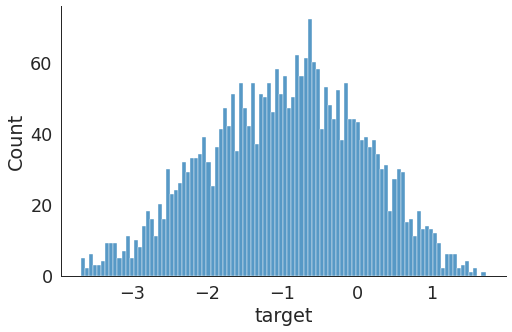

In [ ]:
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_train, x="target", kind="hist", bins = 100, aspect = 1.5)

sumsquare_error         aic           bic  kl_div
beta            0.101427  428.251094 -28982.293255     inf
norm            0.134853  420.893851 -28190.945668     inf
lognorm         0.141371  423.352669 -28049.224012     inf
gamma           0.145586  422.907384 -27965.967679     inf
burr            0.185676  431.419721 -27268.687307     inf

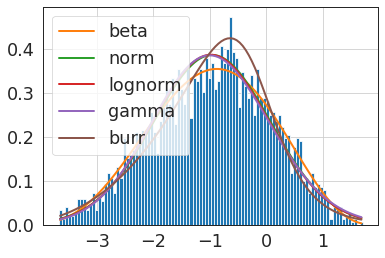

In [ ]:
target = df_train["target"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error') #miglior distribuzione per questi dati

{'beta': (4.460517579100131,
  3.7619788101569087,
  -4.378426752370665,
  6.30093820697417)}

## Grafico Distribuzione Frequenza

Distribuzione dei dati in base alla frequenza di utilizzo delle parole

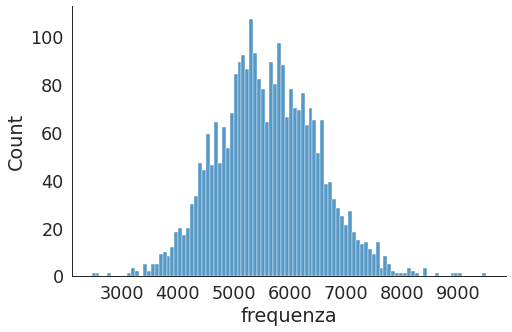

In [ ]:
sns.displot(data=df_train, x="frequenza", kind="hist", bins = 100, aspect = 1.5)

sumsquare_error          aic           bic  kl_div
gamma       9.386153e-08  2078.242487 -68363.092795     inf
beta        9.386438e-08  2080.267198 -68355.057549     inf
lognorm     9.401956e-08  2076.924490 -68358.325497     inf
norm        9.895127e-08  2092.619556 -68221.387550     inf
burr        4.921811e-07  2335.797132 -63659.131466     inf

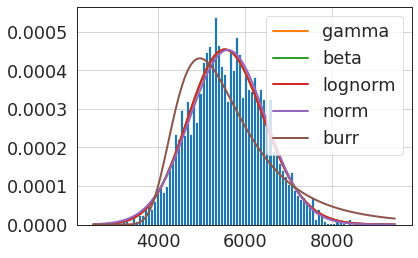

In [ ]:
target = df_train["frequenza"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error') #miglior distribuzione per questi dati

{'gamma': (164.31656359527264, -5679.769055396299, 68.65772215411096)}

## Grafico Distribuzione Aoa

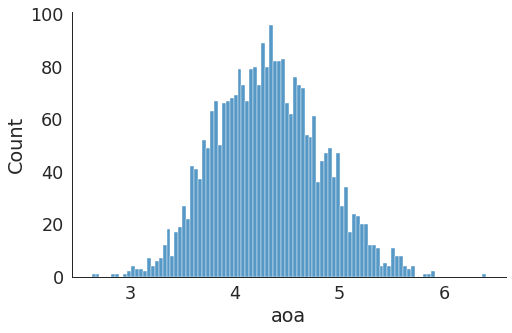

In [ ]:
sns.displot(data=df_train, x="aoa", kind="hist", bins = 100, aspect = 1.5)

sumsquare_error         aic           bic  kl_div
beta            0.225166  535.961846 -26722.192425     inf
gamma           0.233723  517.798488 -26624.437566     inf
lognorm         0.234703  516.941282 -26612.569149     inf
norm            0.264440  529.330682 -26282.442505     inf
burr            0.390621  458.688741 -25160.936222     inf

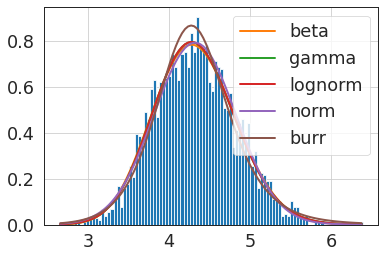

In [ ]:
target = df_train["aoa"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error') #miglior distribuzione per questi dati

{'beta': (19.09868200821671,
  33.549475717987505,
  1.5324932109345981,
  7.679213541401189)}

## Grafico percentuale parole conosciute

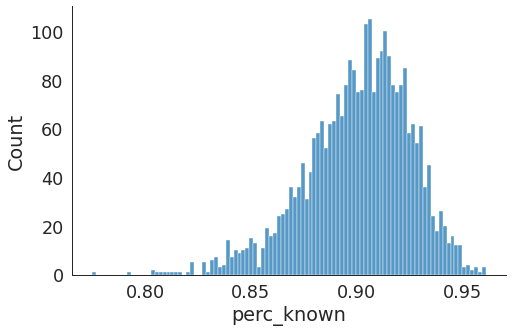

In [ ]:
sns.displot(data=df_train, x="perc_known", kind="hist", bins = 100, aspect = 1.5)

sumsquare_error         aic          bic  kl_div
beta          103.850638  -51.158590 -9338.796947     inf
burr          142.609415 -111.304434 -8439.977298     inf
norm          254.579346   96.614422 -6813.564603     inf
lognorm       255.031362  105.869102 -6800.587735     inf
gamma        6375.137452 -116.276507  2321.418924     inf

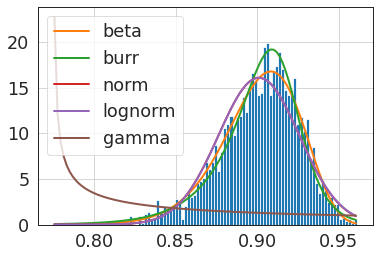

In [ ]:
target = df_train["perc_known"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error') #miglior distribuzione per questi dati

{'beta': (5250227.832902664,
  11.291008721596512,
  -38631.63307682732,
  38632.61711020717)}

## Grafico parole uniche

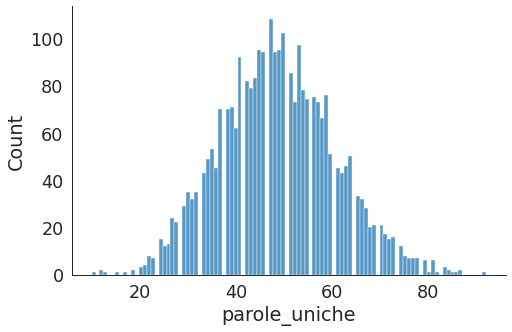

In [ ]:
sns.displot(df_train, x = 'parole_uniche', kind="hist", bins = 100, aspect = 1.5)

sumsquare_error          aic           bic  kl_div
beta            0.006665  1088.761093 -36697.859112     inf
lognorm         0.006665  1078.847066 -36705.789062     inf
gamma           0.006665  1079.389939 -36705.788915     inf
norm            0.006690  1079.859490 -36702.989246     inf
burr            0.006818  1051.314612 -36633.516254     inf

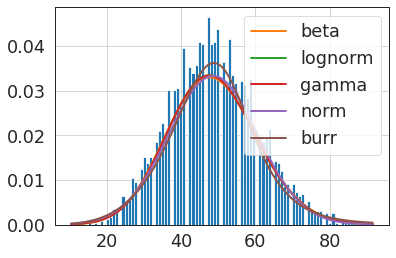

In [ ]:
target = df_train["parole_uniche"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error') #miglior distribuzione per questi dati

{'beta': (20.56867367567295,
  37.8904491981218,
  -19.269863766787395,
  193.03717116806328)}

## Grafico numero frasi e lunghezza frasi

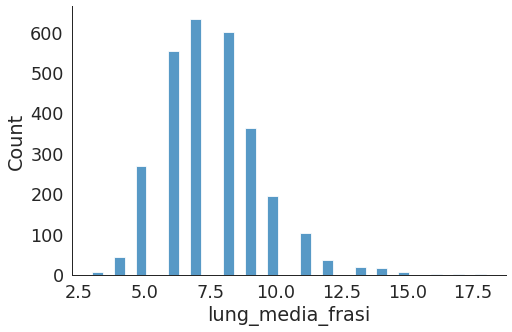

In [ ]:
sns.displot(df_train, x = 'lung_media_frasi', kind="hist", aspect = 1.5)

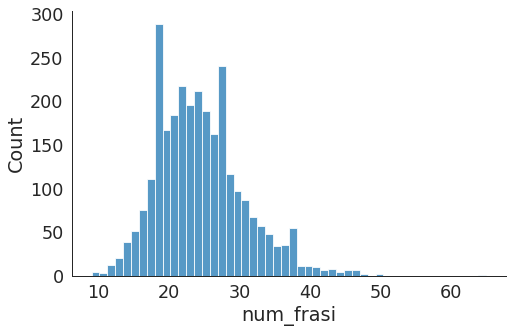

In [ ]:
sns.displot(df_train, x = 'num_frasi', kind="hist" , aspect = 1.5)

sumsquare_error          aic           bic  kl_div
lognorm         6.182288   871.208235 -17342.212209     inf
gamma           6.183073   895.604031 -17341.852307     inf
beta            6.183073   897.626368 -17333.902718     inf
burr            6.187431   799.227788 -17331.906189     inf
norm            6.209766  1119.766805 -17337.593206     inf

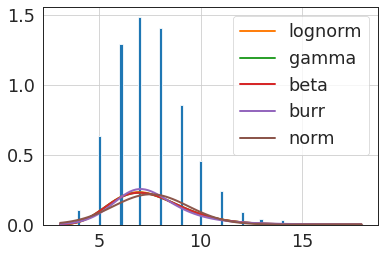

In [ ]:
target = df_train["lung_media_frasi"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'lognorm': (0.22854904769126888, -0.37113176655107794, 7.711815024897856)}

sumsquare_error          aic           bic  kl_div
lognorm         0.069387  1227.262852 -30066.147436     inf
burr            0.069416  1112.285086 -30057.015837     inf
gamma           0.069480  1266.883880 -30062.359604     inf
beta            0.069640  1324.827190 -30047.882015     inf
norm            0.071844  1644.359773 -29975.465730     inf

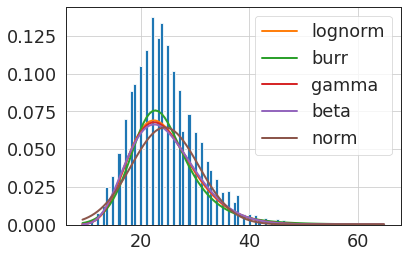

In [ ]:
target = df_train["num_frasi"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'lognorm': (0.23214589827414234, -1.809192404439313, 25.5616670519319)}

## Grafico numero parole

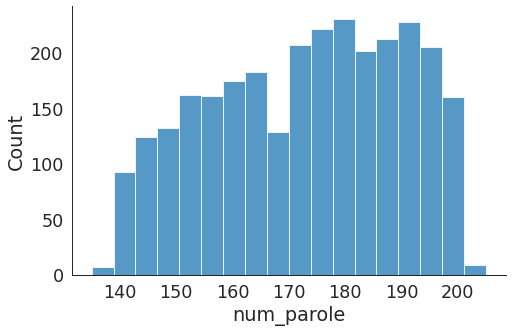

In [ ]:
sns.displot(df_train, x = 'num_parole', kind="hist", aspect = 1.5)

sumsquare_error          aic           bic  kl_div
beta            0.011637   882.266880 -35118.261338     inf
norm            0.013279   898.935205 -34760.228050     inf
gamma           0.013332   901.149766 -34740.856675     inf
burr            0.014735   915.992057 -34449.338672     inf
lognorm         0.135672  1123.167661 -28165.844329     inf

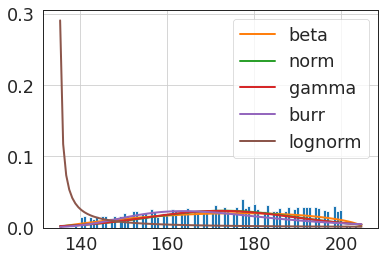

In [ ]:
target = df_train["num_parole"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'beta': (1.9069904979636663,
  1.6076286170360015,
  134.42426165053183,
  70.64367576521602)}

## Grafico percentuale parole uniche

In [ ]:
df_train.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'frequenza', 'aoa', 'perc_known', 'parole_uniche', 'num_frasi',
       'lung_media_frasi', 'num_parole', 'unicità'],
      dtype='object')

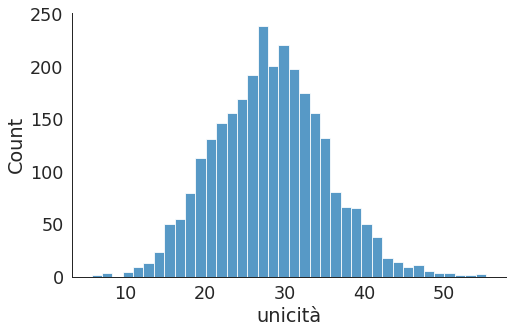

In [ ]:
sns.displot(df_train, x = 'unicità', kind="hist", aspect = 1.5)

sumsquare_error          aic           bic  kl_div
norm            0.001770  1013.528670 -40470.902066     inf
lognorm         0.001845  1005.320083 -40344.961806     inf
beta            0.001846  1008.062612 -40336.084095     inf
gamma           0.001846  1006.062748 -40344.033303     inf
burr            0.001956   969.587048 -40172.457693     inf

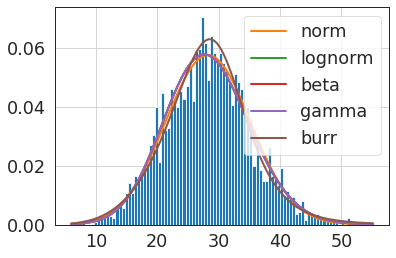

In [ ]:
target = df_train["unicità"].values

f = Fitter(target,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f.get_best(method = 'sumsquare_error')

{'norm': (28.25498870853917, 6.918831398803309)}

# Preprocessing del testo

Trasformare gli excerpt tramite Vectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline

sentences = df_train['excerpt']
vectorizer = TfidfVectorizer(lowercase=True) #Tfid
vectorizer.fit(sentences)
print(vectorizer.vocabulary_)

{'when': 26221, 'the': 24026, 'young': 26745, 'people': 17616, 'returned': 20201, 'to': 24327, 'ballroom': 2366, 'it': 13083, 'presented': 18634, 'decidedly': 6527, 'changed': 4358, 'appearance': 1646, 'instead': 12719, 'of': 16655, 'an': 1402, 'interior': 12828, 'scene': 20985, 'was': 26019, 'winter': 26415, 'landscape': 13756, 'floor': 9605, 'covered': 5906, 'with': 26448, 'snow': 22171, 'white': 26277, 'canvas': 3956, 'not': 16406, 'laid': 13708, 'on': 16733, 'smoothly': 22127, 'but': 3736, 'rumpled': 20665, 'over': 17005, 'bumps': 3652, 'and': 1438, 'hillocks': 11622, 'like': 14125, 'real': 19540, 'field': 9345, 'numerous': 16486, 'palms': 17210, 'evergreens': 8686, 'that': 24022, 'had': 11090, 'decorated': 6558, 'room': 20520, 'were': 26181, 'powdered': 18493, 'flour': 9627, 'strewn': 23058, 'tufts': 24850, 'cotton': 5830, 'also': 1287, 'diamond': 6994, 'dust': 7816, 'been': 2629, 'lightly': 14117, 'sprinkled': 22626, 'them': 24038, 'glittering': 10545, 'crystal': 6164, 'icicles':

Questa parte serve per inserire più colonne come input per il modello. Per far ciò basta togliere il commento e scegliere la colonna da passare in X_train_categ ad esempio in questo unicità. Successivamente è necessario passare al modello X e non la variabile sentences.

In [9]:
'''
enc = DictVectorizer()
X_train_categ = enc.fit_transform(df_train[['unicità']].to_dict('records'))
X_train_categ = df_train['unicità'].values
print(type(X_train_categ))

# Take a sequence of arrays and stack them horizontally to make a single array. 
# Rebuild arrays divided by scipy.sparse.hstack. 
# Note that matrices are sparse. 
# In numerical analysis, a sparse matrix is a matrix in which most of the elements are zero. 

X_tfidf = vectorizer.fit_transform(df_train['excerpt']) 
print(type(X_tfidf))
X = hstack([X_tfidf,X_train_categ]) #Per inserire più colonne
#print(X)
'''

"\nenc = DictVectorizer()\nX_train_categ = enc.fit_transform(df_train[['unicità']].to_dict('records'))\nX_train_categ = df_train['unicità'].values\nprint(type(X_train_categ))\n\n# Take a sequence of arrays and stack them horizontally to make a single array. \n# Rebuild arrays divided by scipy.sparse.hstack. \n# Note that matrices are sparse. \n# In numerical analysis, a sparse matrix is a matrix in which most of the elements are zero. \n\nX_tfidf = vectorizer.fit_transform(df_train['excerpt']) \nprint(type(X_tfidf))\nX = hstack([X_tfidf,X_train_categ]) #Per inserire più colonne\n#print(X)\n"

In [10]:
from sklearn.model_selection import train_test_split

sentences = df_train['excerpt'].values# da inserire al posto di X nel train_test_split
y = df_train['target'].values

sentences_train ,sentences_test, y_train, y_test = train_test_split(sentences,y, test_size=0.25, random_state=1000)# questo serve quando usiamo solo la colonna excerpt
#X_train ,X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1000)

In [11]:
X_train = vectorizer.fit_transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

print(X_train.shape)
print(X_test.shape)

(2125, 23345)
(709, 23345)


# Modelli sviluppati

## Progetto ML: Regression with sklearn

 Modello Sklearn

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse



model_linr = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()


model_linr.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lasso.fit(X_train,y_train)

score_linr = model_linr.score(X_test, y_test)
score_ridge = model_ridge.score(X_test, y_test)
score_lasso = model_lasso.score(X_test, y_test)

y_pred_lin = model_linr.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)
y_pred_lasso = model_lasso.predict(X_test)

MSE1 = mse(y_test, y_pred_lin)
MSE2 = mse(y_test, y_pred_ridge)
MSE3 = mse(y_test, y_pred_lasso)

print('Modello: LinearRegression')
print('Accuracy data: {:.4f}'.format(score_linr))
print('Mean Squared Error: {:.4f}'.format(MSE1))
print('Root Mean Squared Error:', np.sqrt(MSE1))

print('Modello: Ridge Regression')
print('Accuracy data: {:.4f}'.format(score_ridge))
print('Mean Squared Error: {:.4f}'.format(MSE2))
print('Root Mean Squared Error:', np.sqrt(MSE2))

print('Modello: Lasso Regression')
print('Accuracy data: {:.4f}'.format(score_lasso))
print('Mean Squared Error: {:.4f}'.format(MSE3))
print('Root Mean Squared Error:', np.sqrt(MSE3))


Modello: LinearRegression
Accuracy data: 0.4887
Mean Squared Error: 0.5520
Root Mean Squared Error: 0.7429621544654528
Modello: Ridge Regression
Accuracy data: 0.5175
Mean Squared Error: 0.5209
Root Mean Squared Error: 0.7217184244670143
Modello: Lasso Regression
Accuracy data: -0.0000
Mean Squared Error: 1.0796
Root Mean Squared Error: 1.03905829773234


**Score con frequenza, excerpt e percentuale conosciute**

Modello: LinearRegression

> Accuracy data: 0.5144
Mean Squared Error: 0.5242

Modello: Ridge Regression

> Accuracy data: 0.5219
Mean Squared Error: 0.5161

Modello: Lasso Regression

> Accuracy data: 0.0017
Mean Squared Error: 1.0778


**Score con excerpt e parole uniche**

Modello: LinearRegression

> Accuracy data: 0.5180
Mean Squared Error: 0.5203

Modello: Ridge Regression

> Accuracy data: 0.5337
Mean Squared Error: 0.5034

Modello: Lasso Regression

> Accuracy data: 0.2712
Mean Squared Error: 0.7868

**Score con excerpt e unicità**

Modello: LinearRegression

>Accuracy data: 0.5024
Mean Squared Error: 0.5372

Modello: Ridge Regression

> Accuracy data: 0.5189
Mean Squared Error: 0.5194

Modello: Lasso Regression

> Accuracy data: 0.2177
Mean Squared Error: 0.8446






In [ ]:
print(f'alpha = {model_linr.intercept_}')
print(f'betas = {model_linr.coef_}')

alpha = -0.9103611554921989
betas = [ 0.23775053 -1.00096835  0.01253526 ... -0.45113892  0.00773862
 -0.19572725]


Predict Test Sklearn

In [ ]:
prova = df_train['excerpt'][0:2].values

print(prova)

['when the young people returned to the ballroom, it presented a decidedly changed appearance. instead of an interior scene, it was a winter landscape.\nthe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. the numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nat each end of the room, on the wall, hung a beautiful bear-skin rug.\nthese rugs were for prizes, one for the girls and one for the boys. and this was the game.\nthe girls were gathered at one end of the room and the boys at the other, and one end was called the north pole, and the other the south pole. each player was given a small flag which they were to plant on reaching the pole.\nthis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [ ]:
df_train['target'][0:2]

0   -0.340259
1   -0.315372
Name: target, dtype: float64

In [ ]:
prova = vectorizer.transform(prova)
#quando si usano più colonne da passere al modello bisogna passare anche questo
#X_train_categ = enc.fit_transform(df_train[['unicità']][0:2].to_dict('records'))
#prova = hstack([prova,X_train_categ])
print(prova.shape)

(2, 23345)


In [ ]:
#prova = vectorizer.transform(prova)
#print(prova)
#prediction = model_ridge.predict(prova)
prediction = model_linr.predict(prova)
#prediction = model_lasso.predict(prova)
print(prediction)
#[-0.34025889 -0.31537255]

[-0.34025889 -0.31537255]


In [ ]:
test = df_test['excerpt']
df_test['perc_known'] = 0
df_test['frequenza'] = 0
df_test['parole_uniche'] = 0
df_test['unicità'] = 0
print(test)

#prova = vectorizer.transform(test)
pred = vectorizer.transform(test)
#X_train_categ = enc.fit_transform(df_test[['unicità']].to_dict('records'))
#pred = hstack([prova,X_train_categ])
print(pred.shape)

#pred2 = clf.predict(pred)
#pred = np.asarray(pred.sort_indices()).astype('float32')
#final_pred = model_linr.predict(pred)
final_pred = model_ridge.predict(pred)
predictions = pd.DataFrame()
predictions['id'] = df_test['id']
predictions['target'] = final_pred
predictions.to_csv("/content/drive/My Drive/Uni Magistrale/Machine Learning/Progetto ML/commonlitreadabilityprize/submission.csv", index=False)
predictions

0    My hope lay in Jack's promise that he would ke...
1    Dotty continued to go to Mrs. Gray's every nig...
2    It was a bright and cheerful scene that greete...
3    Cell division is the process by which a parent...
4    Debugging is the process of finding and resolv...
5    To explain transitivity, let us look first at ...
6    Milka and John are playing in the garden. Her ...
Name: excerpt, dtype: object
(7, 23345)


id    target
0  c0f722661 -1.576819
1  f0953f0a5 -0.566100
2  0df072751 -0.494685
3  04caf4e0c -1.483863
4  0e63f8bea -1.352775
5  12537fe78 -0.709927
6  965e592c0 -0.195866

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_lin})
df

Actual  Predicted
0    0.199687  -0.486234
1    0.088148  -0.850307
2   -1.198192  -2.904125
3   -1.199957  -0.872710
4   -2.330077  -1.958675
..        ...        ...
704 -2.934846  -1.073790
705 -1.672911  -0.977461
706 -0.262954  -1.352074
707 -1.311346  -1.848958
708 -1.302688  -1.441962

[709 rows x 2 columns]

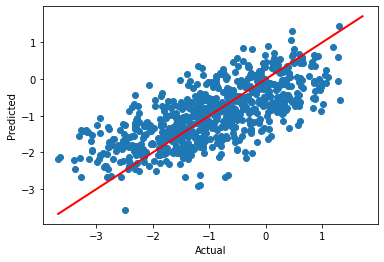

In [ ]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, y_pred_lin)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_ridge})
df

Actual  Predicted
0    0.199687  -0.819590
1    0.088148  -0.952715
2   -1.198192  -2.322807
3   -1.199957  -0.779653
4   -2.330077  -2.048091
..        ...        ...
704 -2.934846  -1.088968
705 -1.672911  -1.221913
706 -0.262954  -1.490546
707 -1.311346  -1.649678
708 -1.302688  -1.294568

[709 rows x 2 columns]

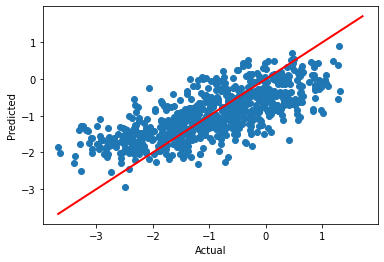

In [ ]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, y_pred_ridge)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

## Progetto ML: Linear Regression with Xgboost

Extreme Gradient Boosting (XGBoost) è una libreria open source che fornisce un'implementazione efficiente ed efficace dell'algoritmo di potenziamento del gradiente.

In [ ]:
import xgboost as xgb
print(xgb.__version__)

0.90


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from sklearn.metrics import r2_score

Tutti gli oggetti del punteggio seguono la convenzione secondo cui i valori restituiti più alti sono migliori dei valori restituiti più bassi. Pertanto le metriche che misurano la distanza tra il modello e i dati, come metrics.mean_squared_error, sono disponibili come neg_mean_squared_error che restituiscono il valore negato della metrica.

In [ ]:
model_xgboost = xgb.XGBRegressor(verbosity=0)
model_xgboost2= xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objective='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, seed= 42,
                           min_child_weight=1.5, reg_alpha=0.75, reg_lambda=0.45,
                           subsample=0.6)



In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, random_state=1)
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model_xgboost, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = cross_val_score(model_xgboost2, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
# force scores to be positive
scores = absolute(scores)

In [ ]:
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.822 (0.038)



Modello 1

> Mean MAE: 0.665 (0.058)



Modello 2

> Mean MAE: 0.698 (0.059)

Modello 3


>Mean MAE: 0.678 (0.065)



In [ ]:
lambda_values = [1, 10, 50, 100]
for val in lambda_values:
    xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, reg_lambda=val)


    xgb_reg.fit(X_train, y_train)

    y_pred = xgb_reg.predict(X_test)
    y_true = y_test

    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)

    R_squared = r2_score(y_true, y_pred)

    print("lambda = ", val)
    
    print("MSE: %.2f" % MSE)
    print("RMSE: ", np.round(RMSE, 2))
    print("R-Squared: ", np.round(R_squared, 2))
    print()

[15:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
lambda =  1
MSE: 0.70
RMSE:  0.84
R-Squared:  0.35

[15:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
lambda =  10
MSE: 0.69
RMSE:  0.83
R-Squared:  0.36

[15:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
lambda =  50
MSE: 0.71
RMSE:  0.84
R-Squared:  0.35

[15:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
lambda =  100
MSE: 0.70
RMSE:  0.84
R-Squared:  0.35



In [ ]:
# fit model
model_xgboost2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
             n_jobs=2, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [ ]:
y_pred_xgboost = model_xgboost2.predict(X_test)

mse_xgboost = mse(y_test, y_pred_xgboost)
R_squared = r2_score(y_test, y_pred_xgboost)

print("MSE: %.2f" % mse_xgboost)
print("RMSE: %.2f" % np.sqrt(mse_xgboost))
print("R-Squared: ", np.round(R_squared, 2))

MSE: 0.68
RMSE: 0.83
R-Squared:  0.37



Modello 2
> MSE: 0.67
RMSE: 0.82
R-Squared:  0.38


Modello 1

> MSE: 0.67
RMSE: 0.82
R-Squared:  0.38




In [ ]:
y= df_train['target']
y.describe().T

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [ ]:
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

0.3671097866906725

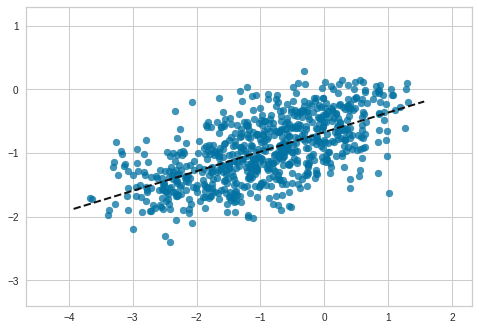

In [ ]:
visualizer = PredictionError(model_xgboost2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

0.3671097866906725

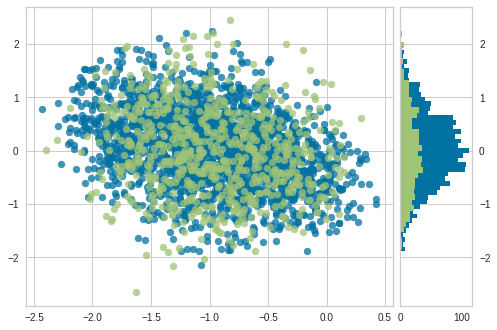

In [ ]:
visualizer = ResidualsPlot(model_xgboost2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  

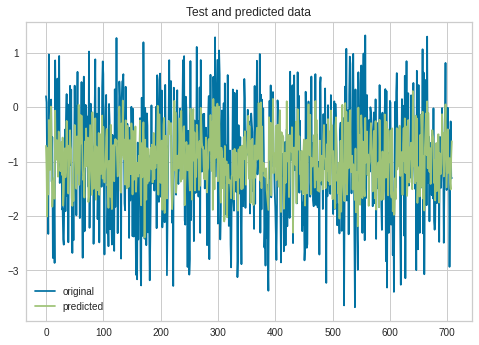

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_xgboost, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

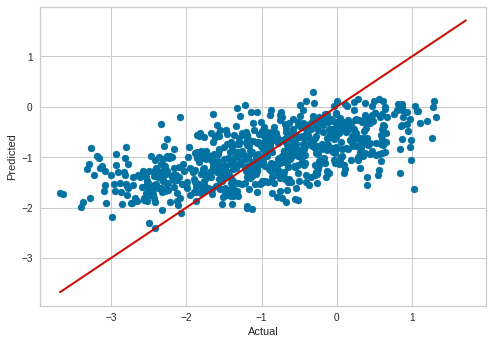

In [ ]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, y_pred_xgboost)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
print((y_test.shape))
print((y_test[:5]))

(709,)
[ 0.19968727  0.08814816 -1.19819232 -1.19995718 -2.33007715]


In [ ]:
print(( y_pred_xgboost.shape))
print(( y_pred_xgboost[:5]))

(709,)
[-0.71224654 -1.1572652  -2.0090604  -0.752591   -1.6042788 ]


## Progetto ML: Linear Regression with keras

In [12]:
sentences = df_train['excerpt'].values
y = df_train['target'].values

vectorizer = CountVectorizer(min_df=0, lowercase=True) #Tfid

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y, test_size=0.25, random_state=1000)#y

vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

print(X_train.shape)
print(X_test.shape)

(2125, 23345)
(709, 23345)


In [13]:
input_dim = X_train.shape[1]  # Number of features
print(input_dim)

23345


### Primo modello

In [14]:
model = Sequential()

model.add(layers.Dense(10, input_dim=input_dim, activation='relu', ))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
'''
model.add(layers.Dense(5, kernel_initializer='ones',
                              kernel_regularizer=tf.keras.regularizers.l1(0.01),
                              activity_regularizer=tf.keras.regularizers.l2(0.01)))
'''                              
#model.add(tf.keras.layers.Dropout(.2,input_shape=(2,)))

model.add(layers.Dense(1, activation='linear'))
#peggiora se si diminuisce il numero di feature per livello
model.compile(loss='mse',optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                233460    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 233,691
Trainable params: 233,691
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, epochs=20,verbose=True, validation_data=(X_test, y_test), batch_size=32) #20 epoche buono

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


67/67 [==============================] - 2s 12ms/step - loss: 0.8746 - mae: 0.7341 - val_loss: 0.5748 - val_mae: 0.6104
Epoch 2/20
67/67 [==============================] - 1s 9ms/step - loss: 0.2960 - mae: 0.4196 - val_loss: 0.5194 - val_mae: 0.5801
Epoch 3/20
67/67 [==============================] - 1s 9ms/step - loss: 0.1069 - mae: 0.2404 - val_loss: 0.5430 - val_mae: 0.5873
Epoch 4/20
67/67 [==============================] - 1s 9ms/step - loss: 0.0517 - mae: 0.1629 - val_loss: 0.5370 - val_mae: 0.5858
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0370 - mae: 0.1356 - val_loss: 0.5437 - val_mae: 0.5922
Epoch 6/20
67/67 [==============================] - 1s 9ms/step - loss: 0.0288 - mae: 0.1186 - val_loss: 0.5431 - val_mae: 0.5911
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0233 - mae: 0.1076 - val_loss: 0.5415 - val_mae: 0.5913
Epoch 8/20
67/67 [==============================] - 1s 9ms/step - loss: 0.0227 - mae: 0.1034 - val_l

In [16]:
from keras.backend import clear_session
clear_session()

In [17]:
loss, mae = model.evaluate(X_train, y_train, verbose=False)
print("Training MSE: {:.4f}".format(loss))
print("Training RMSE: %.2f" % np.sqrt(loss))

loss, mae = model.evaluate(X_test, y_test, verbose=False)
print("Testing MSE:  {:.4f}".format(loss))
print("Testing RMSE: %.2f" % np.sqrt(loss))

Training MSE: 0.0099
Training RMSE: 0.10
Testing MSE:  0.5350
Testing RMSE: 0.73


In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training mae')
    plt.plot(x, val_acc, 'r', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

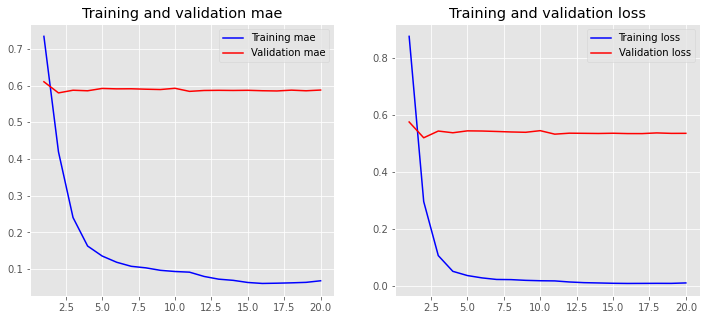

In [19]:
plot_history(history)

Prediction 

In [20]:
prova = df_train['excerpt'][0:2]
print(df_train['target'][0:2])

0   -0.340259
1   -0.315372
Name: target, dtype: float64


In [21]:
prova = vectorizer.transform(prova)
#print(prova)
#prediction = model_ridge.predict(prova)
prediction = model.predict(prova)
#prediction = model_lasso.predict(prova)
print(prediction)

[[-0.3862132 ]
 [-0.31753865]]


In [22]:
test = df_test['excerpt']
print(test)
pred = vectorizer.transform(test)
print(pred.shape)


final_pred = model.predict(pred)
predictions = pd.DataFrame()
predictions['id'] = df_test['id']
predictions['target'] = final_pred
predictions.to_csv("/content/drive/My Drive/Uni Magistrale/Machine Learning/Progetto ML/commonlitreadabilityprize/submission.csv", index=False)
predictions

0    My hope lay in Jack's promise that he would ke...
1    Dotty continued to go to Mrs. Gray's every nig...
2    It was a bright and cheerful scene that greete...
3    Cell division is the process by which a parent...
4    Debugging is the process of finding and resolv...
5    To explain transitivity, let us look first at ...
6    Milka and John are playing in the garden. Her ...
Name: excerpt, dtype: object
(7, 23345)


id    target
0  c0f722661 -1.424010
1  f0953f0a5 -0.415291
2  0df072751 -0.587886
3  04caf4e0c -1.874241
4  0e63f8bea -0.864942
5  12537fe78 -0.060765
6  965e592c0 -0.216388

In [23]:
pred = model.predict(X_test)

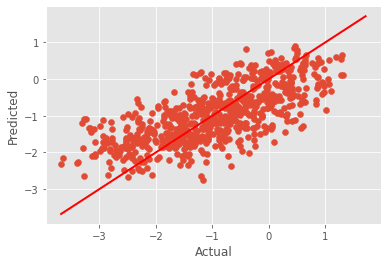

In [24]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

### Secondo modello

In [25]:
#To build a model for hypertuning, we need define the hyperparameter search space 
#in addition to the model architecture.
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=hp_units, input_dim=input_dim, activation='relu', ))
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(units=hp_units, activation='relu'))
    
    model.add(layers.Dense(1, activation='linear'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        loss='mean_squared_error',
        metrics=['mean_squared_error'], 
        optimizer='adam'
    )
    model.summary()
    return model

In [26]:
#Instantiate the tuner to perform the hypertuning
#four tuners are available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn
tuner = kt.Hyperband(
    model_builder,
    objective='val_mean_squared_error',
    max_epochs=15,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                747072    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 749,217
Trainable params: 749,217
Non-trainable params: 0
_________________________________________________________________


In [27]:
#callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

#Run the hyperparameter search. 
#The arguments for the search method are the same as fit()
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[stop_early], verbose=True, batch_size=32)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.""")

Trial 8 Complete [00h 00m 07s]
val_mean_squared_error: 0.514857828617096

Best val_mean_squared_error So Far: 0.511293888092041
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160.


In [40]:
#optimal number of epochs to train the model with the hyperparameters obtained from the search.

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=True, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               3735360   
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 3,787,041
Trainable params: 3,787,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 160), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


67/67 [==============================] - 5s 60ms/step - loss: 0.6920 - mean_squared_error: 0.6920 - val_loss: 0.5319 - val_mean_squared_error: 0.5319
Epoch 2/20
67/67 [==============================] - 4s 64ms/step - loss: 0.2234 - mean_squared_error: 0.2234 - val_loss: 0.5437 - val_mean_squared_error: 0.5437
Epoch 3/20
67/67 [==============================] - 4s 59ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.5289 - val_mean_squared_error: 0.5289
Epoch 4/20
67/67 [==============================] - 4s 53ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.5344 - val_mean_squared_error: 0.5344
Epoch 5/20
67/67 [==============================] - 4s 58ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.5376 - val_mean_squared_error: 0.5376
Epoch 6/20
67/67 [==============================] - 4s 53ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.5237 - val_mean_squared_error: 0.5237
Epoch 7/20
67/67 [===========================

In [29]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 9


In [31]:
#Re-instantiate the hypermodel and train it with the optimal number of epochs

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hyperhistory = hypermodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=best_epoch, verbose=True, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               3735360   
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 3,787,041
Trainable params: 3,787,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 160), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


67/67 [==============================] - 4s 57ms/step - loss: 0.6781 - mean_squared_error: 0.6781 - val_loss: 0.5438 - val_mean_squared_error: 0.5438
Epoch 2/9
67/67 [==============================] - 4s 64ms/step - loss: 0.1882 - mean_squared_error: 0.1882 - val_loss: 0.5542 - val_mean_squared_error: 0.5542
Epoch 3/9
67/67 [==============================] - 3s 49ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.5150 - val_mean_squared_error: 0.5150
Epoch 4/9
67/67 [==============================] - 4s 55ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.5095 - val_mean_squared_error: 0.5095
Epoch 5/9
67/67 [==============================] - 5s 69ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.5091 - val_mean_squared_error: 0.5091
Epoch 6/9
67/67 [==============================] - 4s 57ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.5109 - val_mean_squared_error: 0.5109
Epoch 7/9
67/67 [==============================] -

#### Score 


In [41]:
#evaluate the hypermodel on the test data.
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test mse]:", eval_result)

23/23 [==============================] - 0s 3ms/step - loss: 0.5084 - mean_squared_error: 0.5084
[test loss, test mse]: [0.5083615779876709, 0.5083615779876709]


In [42]:
loss, mse = model.evaluate(X_train, y_train, verbose=False)
print("Training MSE: {:.4f}".format(loss))
print("Training RMSE: %.2f" % np.sqrt(loss))

loss, mse = model.evaluate(X_test, y_test, verbose=False)
print("Testing MSE:  {:.4f}".format(loss))
print("Testing RMSE: %.2f" % np.sqrt(loss))

Training MSE: 0.0088
Training RMSE: 0.09
Testing MSE:  0.5208
Testing RMSE: 0.72


#### Grafico

In [43]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['mean_squared_error']
    val_acc = history.history['val_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training mse')
    plt.plot(x, val_acc, 'r', label='Validation mse')
    plt.title('Training and validation rmse')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

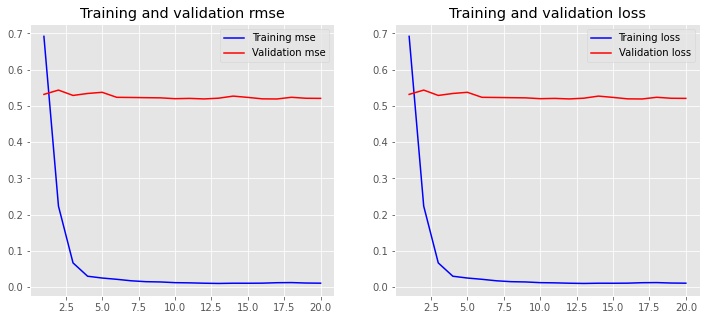

In [44]:
plot_history(history)

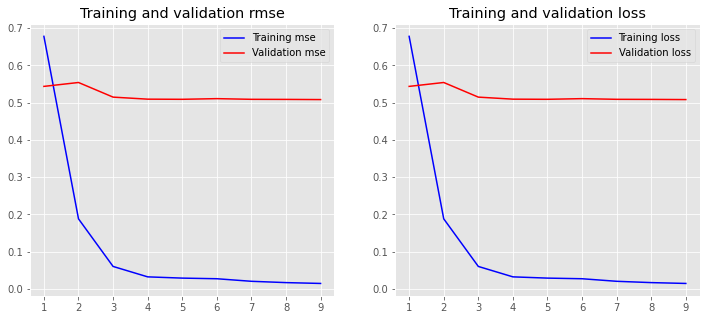

In [45]:
plot_history(hyperhistory)

In [37]:
pred = hypermodel.predict(X_test)

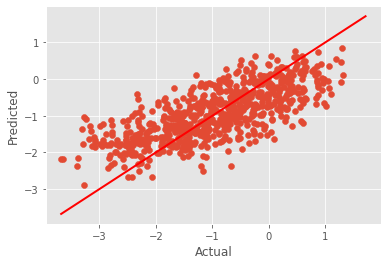

In [38]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [46]:
pred = model.predict(X_test)

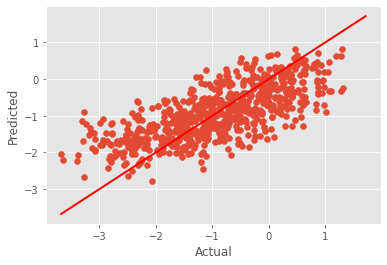

In [47]:
fig, ax = plt.subplots()
y=df_train['target']
ax.scatter(y_test, pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linewidth=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()